# Fault detection

We'll consider a problem of identifying faults that have occurred in a system based on sensor measurements of system performance.

# Topic references
- [Samar, Sikandar, Dimitry Gorinevsky, and Stephen Boyd. "Likelihood Bounds for Constrained Estimation with Uncertainty." Decision and Control, 2005 and 2005 European Control Conference. CDC-ECC'05. 44th IEEE Conference on. IEEE, 2005.](http://web.stanford.edu/~boyd/papers/pdf/map_bounds.pdf)

# Problem statement

Each of $n$ possible faults occurs independently with probability $p$.
The vector $x \in \lbrace 0,1 \rbrace^{n}$ encodes the fault occurrences, with $x_i = 1$ indicating that fault $i$ has occurred.
System performance is measured by $m$ sensors.
The sensor output is
\begin{equation}
y = Ax + v = \sum_{i=1}^n a_i x_i + v,
\end{equation}
where $A \in \mathbf{R}^{m \times n}$ is the sensing matrix with column $a_i$ being the **fault signature** of fault $i$,
and $v \in \mathbf{R}^m$ is a noise vector where $v_j$ is Gaussian with mean 0 and variance $\sigma^2$.

The objective is to guess $x$ (which faults have occurred) given $y$ (sensor measurements).

We are interested in the setting where $n > m$, that is, when we have more possible faults than measurements.
In this setting, we can expect a good recovery when the vector $x$ is sparse.
This is the subject of compressed sensing.

# Solution approach
To identify the faults, one reasonable approach is to choose $x \in \lbrace 0,1 \rbrace^{n}$ to minimize the negative log-likelihood function

\begin{equation}
\ell(x) = \frac{1}{2 \sigma^2} \|Ax-y\|_2^2 +  \log(1/p-1)\mathbf{1}^T x + c.
\end{equation}

However, this problem is nonconvex and NP-hard, due to the constraint that $x$ must be Boolean.

To make this problem tractable, we can relax the Boolean constraints and instead constrain $x_i \in [0,1]$.

The optimization problem

\begin{array}{ll}
\mbox{minimize} &  \|Ax-y\|_2^2 + 2 \sigma^2 \log(1/p-1)\mathbf{1}^T x\\
\mbox{subject to} &  0 \leq x_i \leq 1, \quad i=1, \ldots n
\end{array}

is convex.
We'll refer to the solution of the convex problem as the **relaxed ML** estimate.

By taking the relaxed ML estimate of $x$ and rounding the entries to the nearest of 0 or 1, we recover a Boolean estimate of the fault occurrences.

# Example

We'll generate an example with $n = 2000$ possible faults, $m = 200$ measurements, and fault probability $p = 0.01$.
We'll choose $\sigma^2$ so that the signal-to-noise ratio is 5.
That is,
\begin{equation}
\sqrt{\frac{\mathbf{E}\|Ax \|^2_2}{\mathbf{E} \|v\|_2^2}} = 5.
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

n = 2000
m = 200
p = 0.01
snr = 5

sigma = np.sqrt(p*n/(snr**2))
A = np.random.randn(m,n)

x_true = (np.random.rand(n) <= p).astype(int)
v = sigma*np.random.randn(m)

y = A.dot(x_true) + v

Below, we show $x$, $Ax$ and the noise $v$.

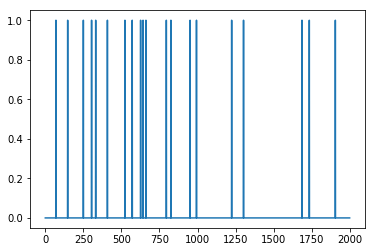

In [2]:
plt.plot(range(n),x_true)

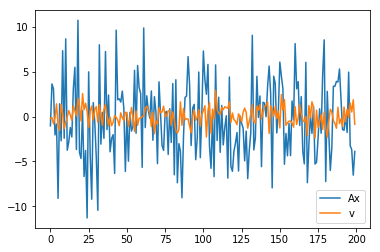

In [3]:
plt.plot(range(m), A.dot(x_true),range(m),v)
plt.legend(('Ax','v'))

# Recovery

We solve the relaxed maximum likelihood problem with CVXPY and then round the result to get a Boolean solution.

In [4]:
%%time
import cvxpy as cp
x = cp.Variable(shape=n)
tau = 2*cp.log(1/p - 1)*sigma**2
obj = cp.Minimize(cp.sum_squares(A*x - y) + tau*cp.sum(x))
const = [0 <= x, x <= 1]
cp.Problem(obj,const).solve(verbose=True)
print("final objective value: {}".format(obj.value))

# relaxed ML estimate
x_rml = np.array(x.value).flatten()

# rounded solution
x_rnd = (x_rml >= .5).astype(int)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.343e+03  -3.862e+03  +5e+04  5e-01  5e-04  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +4.814e+02  -9.580e+02  +8e+03  1e-01  6e-05  2e-01  2e+00  0.8500  1e-02   1  2  2 |  0  0
 2  -2.079e+02  -1.428e+03  +6e+03  1e-01  4e-05  8e-01  2e+00  0.7544  7e-01   2  2  2 |  0  0
 3  -1.321e+02  -1.030e+03  +5e+03  8e-02  3e-05  7e-01  1e+00  0.3122  2e-01   2  2  2 |  0  0
 4  -2.074e+02  -8.580e+02  +4e+03  6e-02  2e-05  6e-01  9e-01  0.7839  7e-01   2  2  2 |  0  0
 5  -1.121e+02  -6.072e+02  +3e+03  5e-02  1e-05  5e-01  7e-01  0.3859  4e-01   2  3  3 |  0  0
 6  -4.898e+01  -4.060e+02  +2e+03  3e-02  8e-06  3e-01  5e-01  0.5780  5e-01   2  2  2 |  0  0
 7  +7.778e+01  -5.711e+01  +8e+02  1e-02  3e-06  1e-01  2e-01  0.9890  4e-01   2  3  2 |  0  0
 8  +1.307e+02  +6.143e+01  +4e+02  6e-03  1e-

# Evaluation

We define a function for computing the estimation errors, and a function for plotting $x$, the relaxed ML estimate, and the rounded solutions.

In [5]:
import matplotlib

def errors(x_true, x, threshold=.5):
    '''Return estimation errors.
    
    Return the true number of faults, the number of false positives, and the number of false negatives.
    '''
    n = len(x_true)
    k = sum(x_true)
    false_pos = sum(np.logical_and(x_true < threshold, x >= threshold))
    false_neg = sum(np.logical_and(x_true >= threshold, x < threshold))
    return (k, false_pos, false_neg)

def plotXs(x_true, x_rml, x_rnd, filename=None):
    '''Plot true, relaxed ML, and rounded solutions.'''
    matplotlib.rcParams.update({'font.size': 14})
    xs = [x_true, x_rml, x_rnd]
    titles = ['x_true', 'x_rml', 'x_rnd']

    n = len(x_true)
    k = sum(x_true)

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))

    for i,x in enumerate(xs):
            ax[i].plot(range(n), x)
            ax[i].set_title(titles[i])
            ax[i].set_ylim([0,1])
            
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        
    return errors(x_true, x_rml,.5)

We see that out of 20 actual faults, the rounded solution gives perfect recovery with 0 false negatives and 0 false positives.

(20, 0, 0)

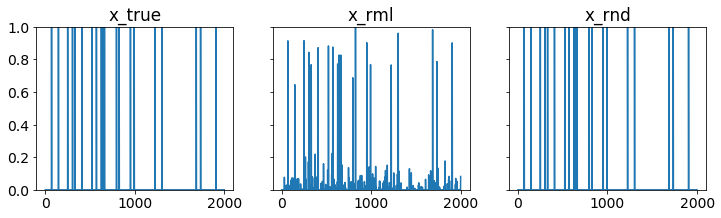

In [6]:
plotXs(x_true, x_rml, x_rnd, 'fault.pdf')